# **Approach 1: Determine optimal coupons without cross-effects**

## **Preparing the environment and loading the data**

In [1]:
import numpy as np
import pandas as pd

from Pipeline import *
import Discount

In [2]:
DATA_PATH = '/Users/leonhagel/Documents/coding/github/mlim-g2/data/'
EXPORT_PATH = '/Users/leonhagel/Documents/coding/github/mlim-g2/export/'

In [3]:
files = {
    'data': [
        #DATA_PATH + 'baskets.parquet',
        DATA_PATH + 'coupon_index.parquet', 
        #DATA_PATH + 'coupons.parquet', 
        #DATA_PATH + 'merged.parquet',
        DATA_PATH + 'clean.parquet', 
        DATA_PATH + 'prepare.parquet'
    ], 
    'mappings': [
        EXPORT_PATH + 'product_histories.parquet',
        EXPORT_PATH + 'prices.parquet',
    ]
}

<br>

## **Discount model: Class definition and pipeline**

In [4]:
discount_model = Discount.No_Cross_Effects()
discount_model.load(files)

# reduce file sizes
for name, df in discount_model.data.items():
    discount_model.data[name] = discount_model.reduce_data_size(discount_model.data[name])

In [9]:
discount_model.prepare(week=(86,90))

/Applications/Conda/anaconda3/envs/mlim/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[prepare] itertools... (elapsed time: 00:00)
[prepare] merge... (elapsed time: 00:02)
[prepare] cleaning... (elapsed time: 00:04)


  0%|          | 948/2500000 [00:00<4:04:46, 170.16it/s]

[prepare] feature creation... (elapsed time: 02:14)


100%|██████████| 2500000/2500000 [02:37<00:00, 15867.74it/s]

[prepare] done (elapsed time: 14:01)


,shopper,week,product,price,discount,purchased,weeks_since_last_purchase,trend_1,trend_3,trend_5,product_freq
0,0,86,0,688.0,0.0,0.0,104.0,0.0,0.000000,0.0,0.000000
1,0,86,1,560.0,0.0,0.0,104.0,0.0,0.000000,0.0,0.000000
2,0,86,2,773.0,0.0,0.0,104.0,0.0,0.000000,0.0,0.000000
3,0,86,3,722.0,0.0,0.0,104.0,0.0,0.000000,0.0,0.000000
4,0,86,4,620.0,0.0,0.0,16.0,0.0,0.000000,0.0,0.093023
...,...,...,...,...,...,...,...,...,...,...,...
2499995,1999,90,245,549.0,0.0,0.0,1.0,1.0,0.333333,0.2,0.133333
2499996,1999,90,246,702.0,0.0,0.0,104.0,0.0,0.000000,0.0,0.000000
2499997,1999,90,247,670.0,0.0,0.0,104.0,0.0,0.000000,0.0,0.000000
2499998,1999,90,248,490.0,0.0,0.0,104.0,0.0,0.000000,0.0,0.000000


In [11]:
discount_model.dump(DATA_PATH, 'data')

In [5]:
top_coupons = discount_model.pipeline(90, 4, [0.15, 0.2, 0.25, 0.3])
top_coupons

[discount] train-log-loss: 0.076118548022094


,shopper,week,coupon,product,discount
1171,0,90,0,171,0.15
1076,0,90,1,76,0.15
1157,0,90,2,157,0.15
1067,0,90,3,67,0.15
1004,0,90,4,4,0.3
...,...,...,...,...,...
2499825,1999,90,0,75,0.15
2499963,1999,90,1,213,0.15
2499791,1999,90,2,41,0.15
2499803,1999,90,3,53,0.25


<br>

## **Manual implementation**

### **Training the model**

In [7]:
X_train, y_train, X_test, y_test = discount_model.train_test_split(89, 4)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head()

(2000000, 9) (2000000,) (500000, 9) (500000,)


,price,discount,weeks_since_last_purchase,trend_1,trend_3,trend_5,product_freq,shopper_WOE,product_WOE
21000,688.0,0.0,103.0,0.0,0.0,0.0,0.000000,0.039796,-0.541070
21001,560.0,0.0,103.0,0.0,0.0,0.0,0.000000,0.039796,0.638078
21002,773.0,0.0,103.0,0.0,0.0,0.0,0.000000,0.039796,-0.776683
21003,722.0,0.0,103.0,0.0,0.0,0.0,0.000000,0.039796,-1.401178
21004,620.0,0.0,15.0,0.0,0.0,0.0,0.094118,0.039796,-0.128700


<AxesSubplot:>

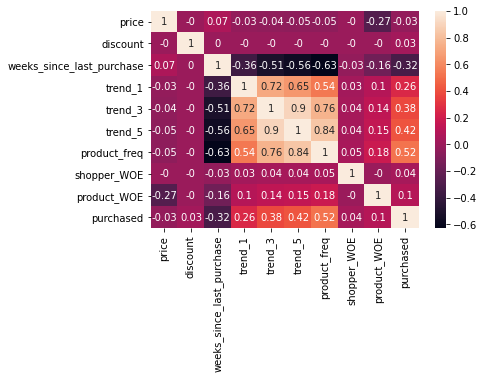

In [8]:
import seaborn as sns
sns.heatmap(X_train.join(y_train).corr().round(2), annot=True)

In [9]:
model = discount_model.fit('lgbm', X_train, y_train)

In [10]:
y_hat = {}

In [11]:
y_hat['train'] = discount_model.predict(model, X_train)
y_hat['test'] = discount_model.predict(model, X_test)

In [12]:
scores = {}
scores['train'] = discount_model.score(y_train, y_hat['train'])
scores['test'] = discount_model.score(y_test, y_hat['test'])
scores

{'train': 0.07631113321309001, 'test': 0.07679777761445356}

<br>

### **Predicting purchase probabilities**

In [13]:
# X_zero: model input for the target week and zero discounts

X_train, y_train, X_zero, _ = discount_model.train_test_split(89, 4)
X_zero['discount'] = 0

#X_train, y_train, X_zero, _ = discount_model.train_test_split(90, 5)
model = discount_model.fit('lgbm', X_train, y_train)
discount_model.score(y_train, discount_model.predict(model, X_train))

0.07631113321309001

In [14]:
X_train['discount'].value_counts()

0.00    1960000
0.30       5825
0.25       5758
0.10       5732
0.40       5715
0.15       5659
0.35       5656
0.20       5655
Name: discount, dtype: int64

In [15]:
X_zero.head()

,price,discount,weeks_since_last_purchase,trend_1,trend_3,trend_5,product_freq,shopper_WOE,product_WOE
22000,688.0,0,103.0,0.0,0.0,0.0,0.000000,0.039796,-0.541070
22001,560.0,0,103.0,0.0,0.0,0.0,0.000000,0.039796,0.638078
22002,773.0,0,103.0,0.0,0.0,0.0,0.000000,0.039796,-0.776683
22003,722.0,0,103.0,0.0,0.0,0.0,0.000000,0.039796,-1.401178
22004,620.0,0,19.0,0.0,0.0,0.0,0.089888,0.039796,-0.128700


In [16]:
prepare.loc[X_zero.index,:].head()

,shopper,week,product,price,discount,purchased,weeks_since_last_purchase,trend_1,trend_3,trend_5,product_freq
22000,0,89,0,688.0,0.0,0.0,103.0,0.0,0.0,0.0,0.000000
22001,0,89,1,560.0,0.0,0.0,103.0,0.0,0.0,0.0,0.000000
22002,0,89,2,773.0,0.0,0.0,103.0,0.0,0.0,0.0,0.000000
22003,0,89,3,722.0,0.0,0.0,103.0,0.0,0.0,0.0,0.000000
22004,0,89,4,620.0,0.0,0.0,19.0,0.0,0.0,0.0,0.089888


In [17]:
discounts = [0.15, 0.2, 0.25, 0.3]
X = discount_model._add_discounts(X_zero, discounts)
X

,price,discount,weeks_since_last_purchase,trend_1,trend_3,trend_5,product_freq,shopper_WOE,product_WOE
22000,688.0,0.0,103.0,0.0,0.0,0.0,0.000000,0.039796,-0.541070
22001,560.0,0.0,103.0,0.0,0.0,0.0,0.000000,0.039796,0.638078
22002,773.0,0.0,103.0,0.0,0.0,0.0,0.000000,0.039796,-0.776683
22003,722.0,0.0,103.0,0.0,0.0,0.0,0.000000,0.039796,-1.401178
22004,620.0,0.0,19.0,0.0,0.0,0.0,0.089888,0.039796,-0.128700
...,...,...,...,...,...,...,...,...,...
44499995,549.0,0.3,19.0,0.0,0.0,0.0,0.123596,0.071599,-0.878618
44499996,702.0,0.3,103.0,0.0,0.0,0.0,0.000000,0.071599,-0.343367
44499997,670.0,0.3,103.0,0.0,0.0,0.0,0.000000,0.071599,-1.559153
44499998,490.0,0.3,103.0,0.0,0.0,0.0,0.000000,0.071599,0.837201


In [18]:
revenue = discount_model.get_revenue(X)
revenue

,shopper,week,product,price,discount,probabilities,exp_revenue,d_revenue
22000,0,89,0,688.0,0.0,0.001215,0.835626,0.000000
22001,0,89,1,560.0,0.0,0.001572,0.880500,0.000000
22002,0,89,2,773.0,0.0,0.001122,0.867358,0.000000
22003,0,89,3,722.0,0.0,0.001105,0.797969,0.000000
22004,0,89,4,620.0,0.0,0.098029,60.777925,0.000000
...,...,...,...,...,...,...,...,...
44499995,1999,89,245,549.0,0.3,0.269856,103.705786,30.454597
44499996,1999,89,246,702.0,0.3,0.006693,3.289070,2.410102
44499997,1999,89,247,670.0,0.3,0.003860,1.810538,1.362879
44499998,1999,89,248,490.0,0.3,0.006060,2.078421,1.231422


<br>

### **Creating the final output**

In [19]:
top_coupons = discount_model.get_top_coupons()
top_coupons

,shopper,week,coupon,product,discount
22171,0,89,0,171,0.15
22067,0,89,1,67,0.15
22157,0,89,2,157,0.15
22076,0,89,3,76,0.30
22116,0,89,4,116,0.15
...,...,...,...,...,...
44499810,1999,89,0,60,0.15
44499781,1999,89,1,31,0.20
44499858,1999,89,2,108,0.15
44499791,1999,89,3,41,0.20


<br>

### **Recommended coupons**

<AxesSubplot:>

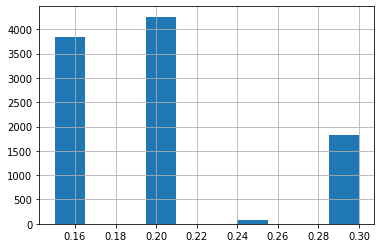

In [20]:
# discount distributions
top_coupons['discount'].hist()